<a href="https://colab.research.google.com/github/zrruziev/Deep_Learning_Practice/blob/main/TDC/C4_W2_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

##Generating the data


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

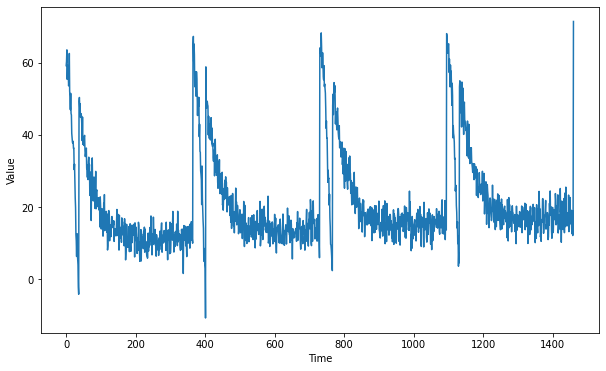

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

# Save all "global" variables within the G class(G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000



# Plot the generated series
plt.figure(figsize=(10,6))
plot_series(G.TIME, G.SERIES)
plt.show()


##Splitting the data

In [17]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_val = time[time_step:]
    series_val = series[time_step:]

    return time_train, series_train, time_val, series_val

In [18]:
# Split the dataset
time_train, series_train, time_val, series_val = train_val_split(G.TIME, G.SERIES)

##Processing the data


In [19]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [20]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


##Define the model architecture

In [28]:
def create_model(window_size=G.WINDOW_SIZE):
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(50, input_shape=[window_size], activation='relu'),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1)
            ])
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=.9))
    
    return model

In [30]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='tb_logs', histogram_freq=1)

In [31]:
# Train the model
model.fit(dataset, epochs=100, callbacks=[tensorboard])

Epoch 1/100
34/34 [==============================] - 1s 4ms/step - loss: 198.6714
Epoch 2/100
34/34 [==============================] - 0s 4ms/step - loss: 69.9885
Epoch 3/100
34/34 [==============================] - 0s 4ms/step - loss: 62.5492
Epoch 4/100
34/34 [==============================] - 0s 4ms/step - loss: 57.0838
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 52.6389
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 49.2323
Epoch 7/100
34/34 [==============================] - 0s 4ms/step - loss: 46.2357
Epoch 8/100
34/34 [==============================] - 0s 4ms/step - loss: 43.6679
Epoch 9/100
34/34 [==============================] - 0s 4ms/step - loss: 41.8602
Epoch 10/100
34/34 [==============================] - 0s 4ms/step - loss: 40.3405
Epoch 11/100
34/34 [==============================] - 0s 4ms/step - loss: 39.2307
Epoch 12/100
34/34 [==============================] - 0s 3ms/step - loss: 38.3496
Epoch 13/100
34/34 [====

##Evaluating the forecast


In [37]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [44]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results


# Save the forecast
dnn_forecast = generate_forecast()


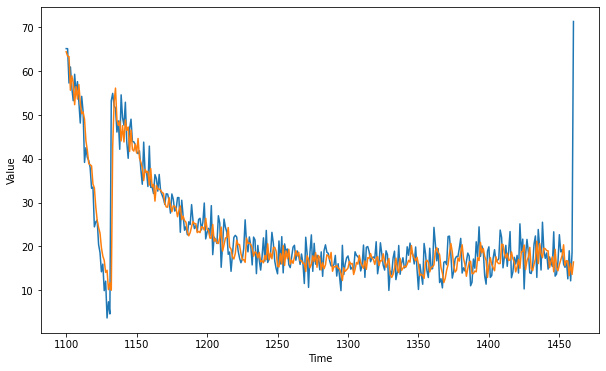

In [45]:
# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_val, series_val)
plot_series(time_val, dnn_forecast)

In [36]:
mse, mae = compute_metrics(series_val, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 28.75, mae: 3.33 for forecast


In [46]:
# Save your model in HDF5 format
model.save('my_model.h5')